### Below is a demo to predict stock trend using LSTM


In [ ]:
import myCrawler as crawler

url = 'https://explorer-web.api.btc.com/v1/eth/miner/stats/list?time_range=4&page=1&size=20'
r = crawler.myRequests(url).json()

In [ ]:
def lengthOfLongestSubstring(s):
    """
    :type s: str
    :rtype: int
    """
    max_length = 0             
    for i in range(len(s)): 
        tmp = set()
        for j in range(i, len(s)):
            tmp.add(s[j])
            if len(tmp) > max_length:
                max_length = len(tmp)
            if len(tmp) != j-i+1:
                break                
            
    return max_length

In [ ]:
def rewards(init_fund, invest_limit, y_return, period):
    if period == 1:
        return init_fund*(1+y_return)+invest_limit
    else:
        return rewards(init_fund, invest_limit, y_return, period-1)*(1+y_return)+invest_limit

In [ ]:
rewards(20, 10, 0.25, 5)

#### 1.0 Data preprocess for lstm

In [1]:
import pandas as pd

df = pd.read_csv('/Users/li/Downloads/sp500.csv')
df = df.sort_values(by = 'Date',ascending=True)
df = df.reset_index(drop=True)
df.tail()

/Users/li/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/li/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,Date,Open,High,Low,Close,Adj Close,Volume
23084,2019-11-25,3117.439941,3133.830078,3117.439941,3133.639893,3133.639893,3511530000
23085,2019-11-26,3134.850098,3142.689941,3131.000000,3140.520020,3140.520020,4595590000
23086,2019-11-27,3145.489990,3154.260010,3143.409912,3153.629883,3153.629883,3033090000
23087,2019-11-29,3147.179932,3150.300049,3139.340088,3140.979980,3140.979980,174302000000
23088,2019-12-02,3143.850098,3144.310059,3110.780029,3113.870117,3113.870117,3268740000


In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,8))
plt.plot(pd.to_datetime(df['Date']), df['Close'])

In [3]:
df[-10000:].to_csv('/Users/li/Downloads/sp500_1.csv')

In [4]:
import numpy as np

class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None
        
    def y_multiclass(self, x): 
        '''相对于窗口第一天涨幅进行分类'''
        pp = x*100
        if pp < -10:
            return 0
        elif pp < -5:
            return 1
        elif pp < 0:
            return 2
        elif pp < 5:
            return 3
        elif pp < 10:
            return 4
        else:
            return 5 

    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows
        
        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        y = [[self.y_multiclass(ele[0])] for ele in y]
        return x,y

    def get_train_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        
        y = [self.y_multiclass(ele) for ele in y]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                
                normalised_window.append(normalised_col)
            
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

In [5]:
cols = ['Close','Open','High','Low','Volume']
data = DataLoader("/Users/li/Downloads/sp500_1.csv",0.85, cols)
seq_len = 20
batch_size = 50
gtdata = data.generate_train_batch(seq_len,batch_size,False)

#### 2.0 LSTM model create

In [9]:
from keras.layers import Dense, Activation, Dropout, LSTM, Flatten
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(units=10,input_shape=(seq_len-1, len(cols)),return_sequences=True))
model.add(Dropout(0.1))
#model.add(LSTM(units=10,input_shape=(seq_len-1, len(cols)),return_sequences=True))
model.add(LSTM(units=10,input_shape=(seq_len-1, len(cols)),return_sequences=False))
#model.add(Dropout(0.1))

model.add(Dense(units=6,activation='softmax'))
#model.add(Dense(units=1,activation='linear'))

# Categorical crossentropy with integer targets
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 

#model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 19, 10)            640       
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 10)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 66        
Total params: 1,546
Trainable params: 1,546
Non-trainable params: 0
_________________________________________________________________


In [16]:
import math
import os
import datetime as dt

epochs = 5
steps_per_epoch = math.ceil((data.len_train-seq_len)/batch_size)
print(steps_per_epoch)

save_fname = os.path.join('saved_models', '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))

callbacks = [
    EarlyStopping(monitor='acc', patience=15),
    ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)]

data_gen = data.generate_train_batch(seq_len, batch_size, True)

model.fit_generator(
        data_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=callbacks
    )


170
Epoch 1/5
170/170 [==============================] - 5s 32ms/step - loss: 0.4456 - acc: 0.8133
Epoch 2/5
170/170 [==============================] - 5s 30ms/step - loss: 0.4421 - acc: 0.8164
Epoch 3/5
170/170 [==============================] - 5s 31ms/step - loss: 0.4389 - acc: 0.8188
Epoch 4/5
170/170 [==============================] - 5s 30ms/step - loss: 0.4346 - acc: 0.8205
Epoch 5/5
170/170 [==============================] - 5s 30ms/step - loss: 0.4344 - acc: 0.8192


In [17]:
x_test, y_test = data.get_test_data(
        seq_len=seq_len,
        normalise=True
    )

In [20]:
predictions = model.predict(x_test)

In [25]:
p = 0
for i in range(len(predictions)):
    if np.argmax(predictions[i]) == y_test[i][0]:
        p += 1
print(p*1./len(predictions))

0.8695945945945946


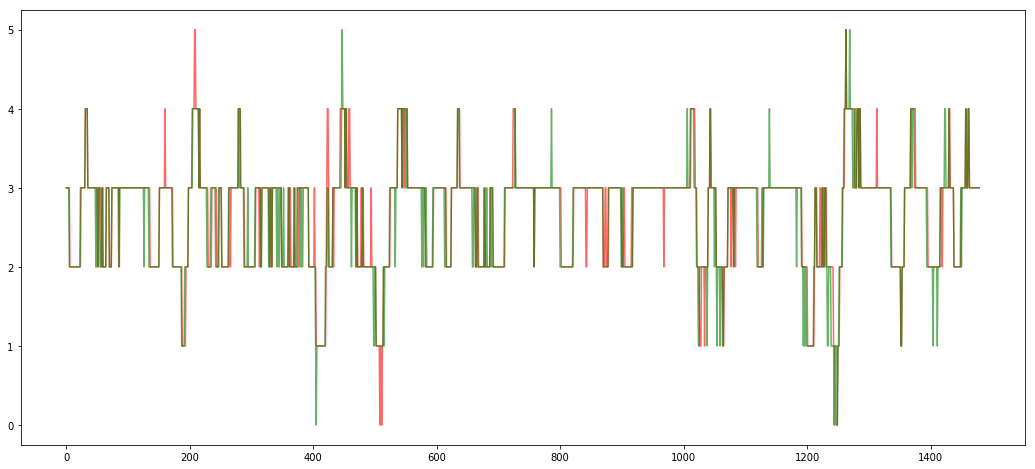

In [31]:
plt.figure(figsize=(18,8))

plt.plot([i for i in range(len(predictions))],[np.argmax(predictions[i]) for i in range(len(predictions))],'r',
        [i for i in range(len(predictions))],[y_test[i][0] for i in range(len(y_test))],'g',alpha=0.6)

In [34]:
np.log2(831600)

19.665530232633095